In [53]:
using TSML
using TSML.Utils
using TSML.TSMLTypes
using TSML.TSMLTransformers
using TSML.Statifiers
using TSML.DataReaders
using TSML.DataWriters
using TSML.Monotonicers
using TSML.Monotonicers: ismonotonic
using TSML.Outliernicers

using DataFrames
using Dates
using Random

UndefVarError: UndefVarError: CSVWriters not defined

In [2]:
try
    import AbstractPlotting
catch
    using Pkg
    Pkg.add("AbstractPlotting")
    import AbstractPlotting
end
try
    import Makie
catch
    using Pkg
    Pkg.add("Makie")
    import Makie
end

In [3]:
try
    using StatsMakie
catch
    using Pkg
    Pkg.add("StatsMakie")
    using StatsMakie
end

## Introduce some missing data

In [34]:
Random.seed!(144)
dt=[missing;rand(1:10,3);missing;missing;missing;rand(1:5,3)]
dat = DataFrame(Date= DateTime(2017,12,31,1):Dates.Hour(1):DateTime(2017,12,31,10) |> collect,Value = dt)

,Date,Value
,DateTime,Int64⍰
1,2017-12-31T01:00:00,missing
2,2017-12-31T02:00:00,9
3,2017-12-31T03:00:00,7
4,2017-12-31T04:00:00,9
5,2017-12-31T05:00:00,missing
6,2017-12-31T06:00:00,missing
7,2017-12-31T07:00:00,missing
8,2017-12-31T08:00:00,3
9,2017-12-31T09:00:00,5


In [39]:
using Statistics
m=[1,3,5,2,7,5]
mean=mean(m),st=std(m)

ErrorException: error in method definition: function Statistics.mean must be explicitly imported to be extended

## Get statistics including blocks of missing data

In [5]:
statfier = Statifier(Dict(:processmissing=>true))
fit!(statfier,dat)
res=transform!(statfier,dat)
show(res,allcols=true)

1×26 DataFrame
│ Row │ tstart              │ tend                │ sfreq   │ count │ max   │
│     │ DateTime            │ DateTime            │ Float64 │ Int64 │ Int64 │
├─────┼─────────────────────┼─────────────────────┼─────────┼───────┼───────┤
│ 1   │ 2017-12-31T01:00:00 │ 2017-12-31T10:00:00 │ 0.9     │ 6     │ 9     │

│ Row │ min   │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Int64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 2     │ 6.0     │ 5.83333 │ 2.5     │ 3.0     │ 3.5     │ 8.5     │

│ Row │ q8      │ q9      │ kurtosis │ skewness  │ variation │ entropy  │
│     │ Float64 │ Float64 │ Float64  │ Float64   │ Float64   │ Float64  │
├─────┼─────────┼─────────┼──────────┼───────────┼───────────┼──────────┤
│ 1   │ 9.0     │ 9.0     │ -1.55578 │ -0.118769 │ 0.513332  │ -65.9007 │

│ Row │ autocor  │ pacf     │ bmedian │ bmean   │ bq25    │ bq75    │ 

## Try real data; aggregate by hour

In [45]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvfilter = DataReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))
csvwriter = DataWriter(Dict(:filename=>outputname))
valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Get statistics including blocks of missing data

In [55]:
mpipeline1 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,stfier]
 )
)
fit!(mpipeline1)
respipe1 = transform!(mpipeline1)
show(respipe1,allcols=true)

1×26 DataFrame
│ Row │ tstart              │ tend                │ sfreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 3830  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.35   │ 11.557  │ 9.9     │ 10.0    │ 10.0    │ 12.3    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 13.0    │ 16.0    │ 0.730635 │ 1.41283  │ 0.200055  │ -1.09145e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

## Try imputing and get statistics

In [8]:
mpipeline2 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,valnner,stfier]
 )
)
fit!(mpipeline2)
respipe2 = transform!(mpipeline2)
show(respipe2,allcols=true)

1×26 DataFrame
│ Row │ tstart              │ tend                │ sfreq    │ count │ max     │
│     │ DateTime            │ DateTime            │ Float64  │ Int64 │ Float64 │
├─────┼─────────────────────┼─────────────────────┼──────────┼───────┼─────────┤
│ 1   │ 2014-01-01T00:00:00 │ 2015-01-01T00:00:00 │ 0.999886 │ 8761  │ 18.8    │

│ Row │ min     │ median  │ mean    │ q1      │ q2      │ q25     │ q75     │
│     │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├─────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1   │ 8.5     │ 10.0    │ 11.1362 │ 9.95    │ 10.0    │ 10.0    │ 11.5    │

│ Row │ q8      │ q9      │ kurtosis │ skewness │ variation │ entropy    │
│     │ Float64 │ Float64 │ Float64  │ Float64  │ Float64   │ Float64    │
├─────┼─────────┼─────────┼──────────┼──────────┼───────────┼────────────┤
│ 1   │ 12.0    │ 14.95   │ 2.37274  │ 1.87452  │ 0.187997  │ -2.36714e5 │

│ Row │ autocor │ pacf    │ bmedian │ bmean   

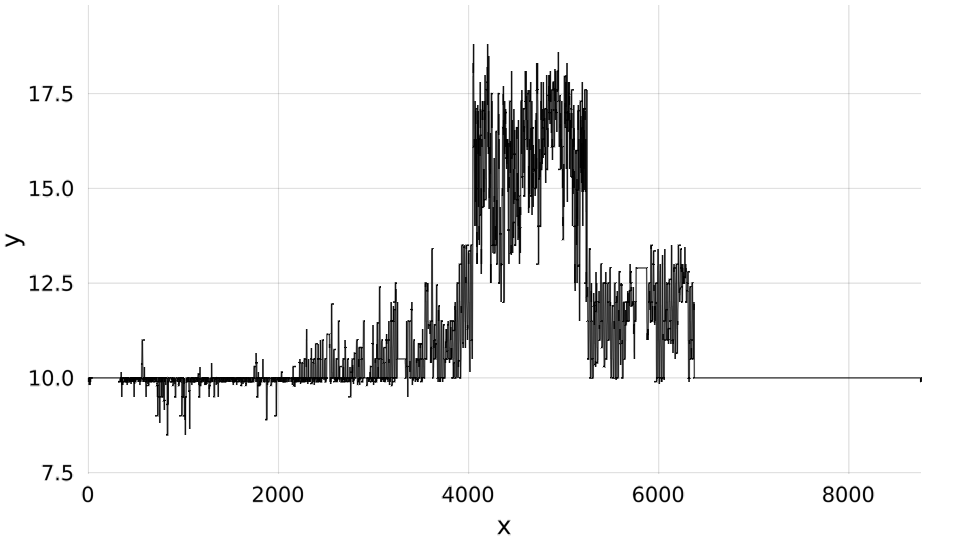

In [29]:
import Makie
using StatsMakie
using AbstractPlotting

mpipeline1 = Pipeline(Dict(
  :transformers => [csvfilter,valgator,valnner]
 )
)
fit!(mpipeline1)
res = transform!(mpipeline1)
res[:Value] = convert(Array{Float64},res[:Value])
lines(res[:Value],markersize=10)

### Monotonicer

In [11]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")

regularfilecsv = DataReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = DataReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = DataReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valnner = DateValNNer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
mono = Monotonicer(Dict());

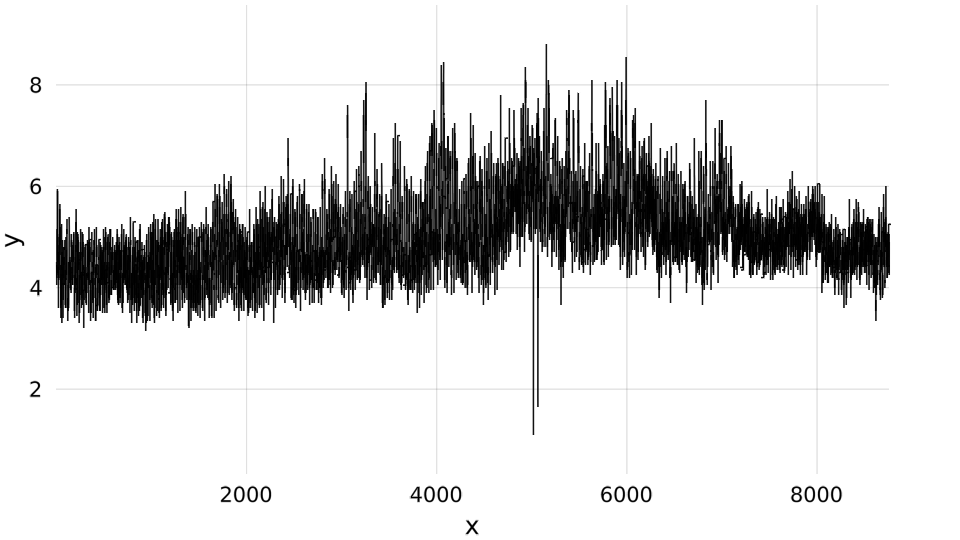

In [31]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner,mono]
 )
)
fit!(regpipeline)
regulardf=transform!(regpipeline)
regulardf[:Value] = skipmissing(regulardf[:Value]) |> collect
lines(regulardf[:Value],markersize=30)

## With Outliernicer

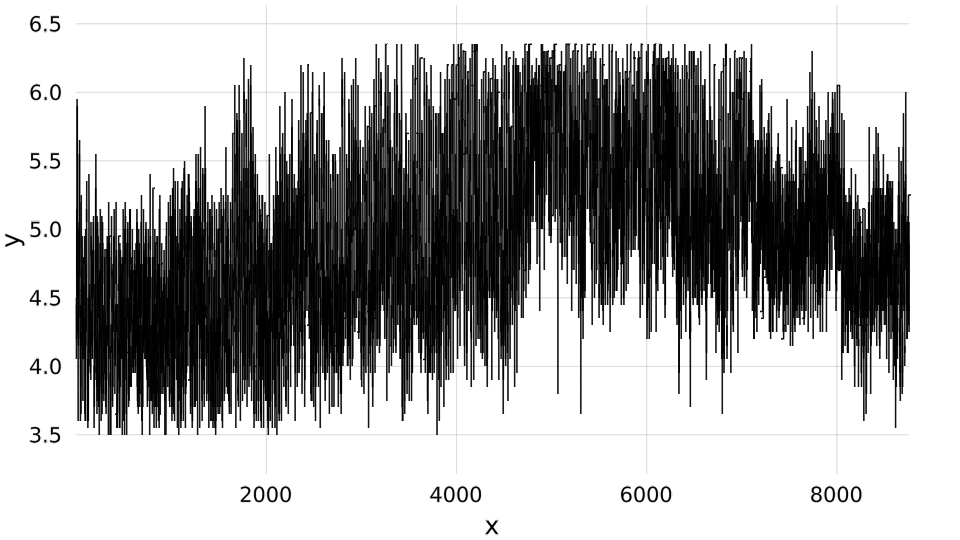

In [17]:
regpipeline = Pipeline(Dict(
  :transformers => [regularfilecsv,valgator,valnner,mono,outliernicer]
 )
)
fit!(regpipeline)
regulardf=transform!(regpipeline)
regulardf[:Value] = skipmissing(regulardf[:Value]) |> collect
lines(regulardf[:Value])

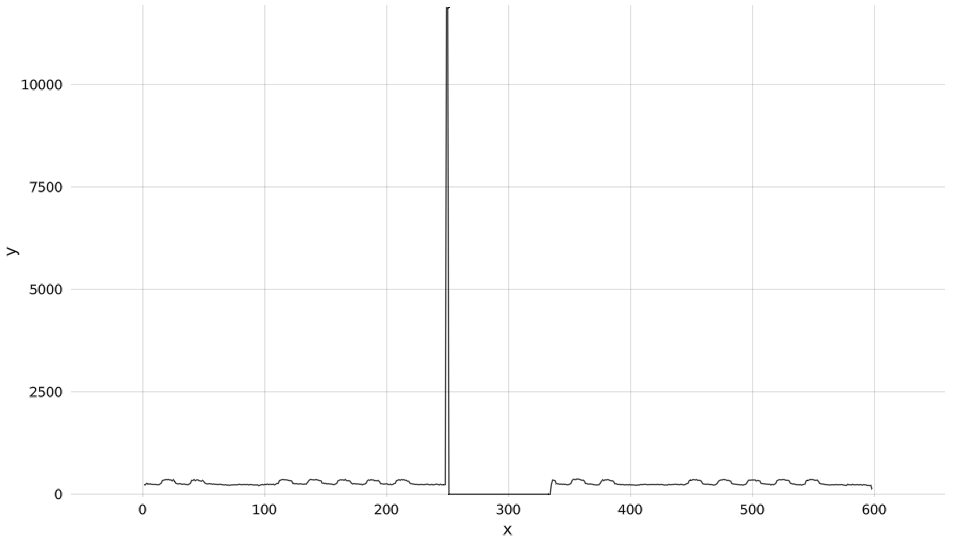

In [18]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono]
 )
)
fit!(monopipeline)
monodf=transform!(monopipeline)
monodf[:Value] = monodf[:Value] |> skipmissing |> collect
lines(monodf[:Value])

## With Outliernicer

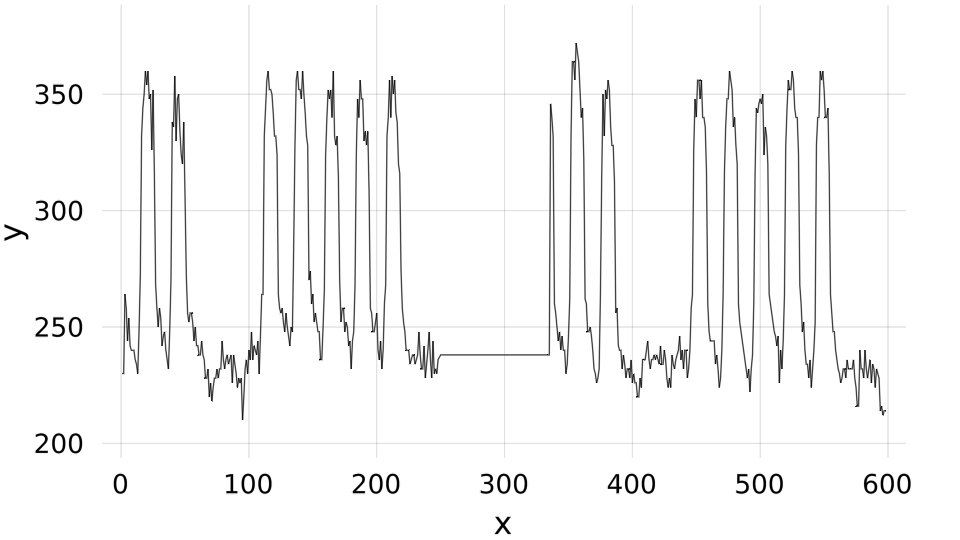

In [28]:
monopipeline = Pipeline(Dict(
  :transformers => [monofilecsv,valgator,valnner,mono,outliernicer]
 )
)
fit!(monopipeline)
monodf=transform!(monopipeline)
monodf[:Value] = monodf[:Value] |> skipmissing |> collect
lines(monodf[:Value])

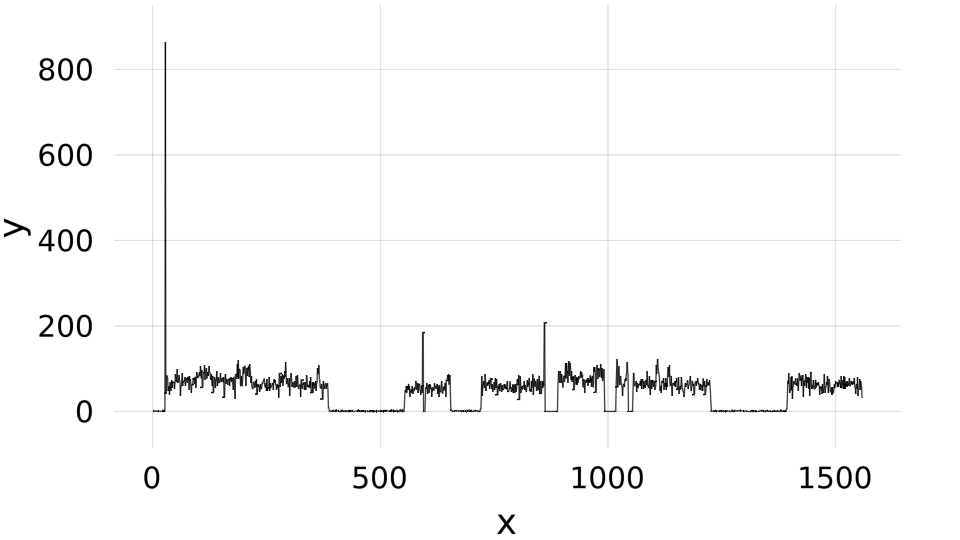

In [19]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono]
 )
)
fit!(dailymonopipeline)
dailymonodf=transform!(dailymonopipeline)
dailymonodf[:Value] = dailymonodf[:Value] |> skipmissing |> collect
lines(dailymonodf[:Value])

## With Outliernicer

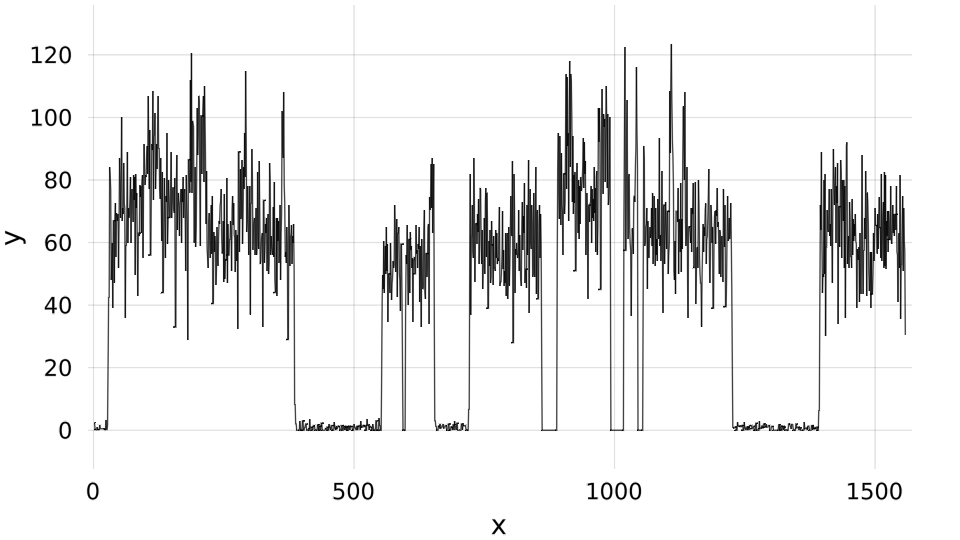

In [31]:
dailymonopipeline = Pipeline(Dict(
  :transformers => [dailymonofilecsv,valgator,valnner,mono,outliernicer]
 )
)
fit!(dailymonopipeline)
dailymonodf=transform!(dailymonopipeline)
dailymonodf[:Value] = dailymonodf[:Value] |> skipmissing |> collect
lines(dailymonodf[:Value])